In [1]:
pip install iminuit

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import multiprocessing as mp
#from multiprocessing import Pool
import copy
from iminuit import Minuit
from pprint import pprint # we use this to pretty print some stuff later
import datetime 
import cProfile
import pstats
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy import units

(18, 9)
Done with 0 0 0 n_s= 8.075744933888629e-14
Done with 1 0 1 n_s= 1.1356516313280884e-12
Done with 2 0 2 n_s= 1.4282821718093508e-05


/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:74: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)


Done with 3 0 3 n_s= 0.82891152157848
Done with 4 0 4 n_s= 1.0495518410046296e-05
Done with 5 0 5 n_s= 0.00013537025206186986
Done with 6 0 6 n_s= 1.0604517501941049
Done with 7 0 7 n_s= 0.00026855020154428885
Done with 8 0 8 n_s= 1.3779066639699997
Done with 9 1 0 n_s= 8.075744933888629e-14
Done with 10 1 1 n_s= 0.00013669007640407262
Done with 11 1 2 n_s= 3.148800836454027e-07
Done with 12 1 3 n_s= 4.927168976646967e-06
Done with 13 1 4 n_s= 2.409758497545463e-05
Done with 14 1 5 n_s= 8.847381601554078
Done with 15 1 6 n_s= 3.786651516440168e-05
Done with 16 1 7 n_s= 8.742935596484905e-05
Done with 17 1 8 n_s= 2.1655179693522413e-07
Done with 18 2 0 n_s= 8.075744933888629e-14
Done with 19 2 1 n_s= 0.8878144713686874
Done with 20 2 2 n_s= 2.048502120157163e-05
Done with 21 2 3 n_s= 1.702462464655809e-06
Done with 22 2 4 n_s= 0.07343531390213778
Done with 23 2 5 n_s= 3.295859159765628
Done with 24 2 6 n_s= 1.295320240580724e-06
Done with 25 2 7 n_s= 3.4212001673521555e-06
Done with 26 

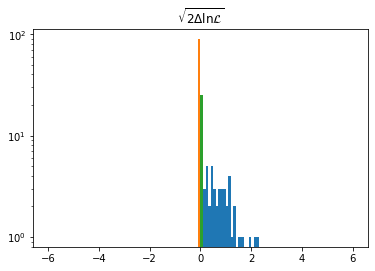

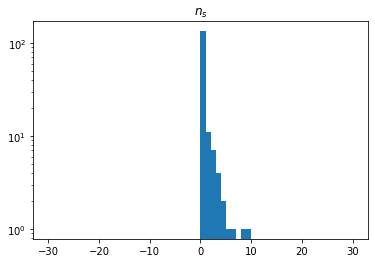

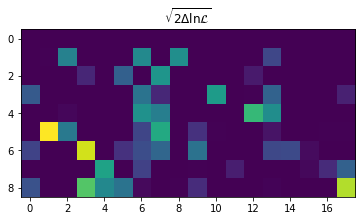

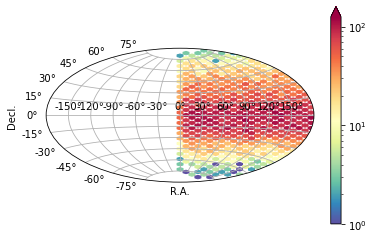

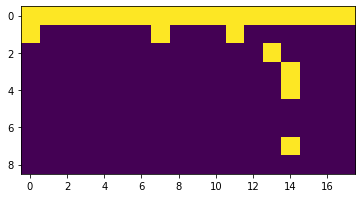

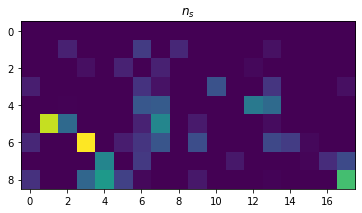

In [8]:
def load_icecube_data(file_name):
    
    # Load up the IceCube data
    icecube_data = np.load(file_name, allow_pickle=True)

    data_sigmas = np.array(icecube_data["data_sigmas"])
    data_ra = np.array(icecube_data["data_ra"])
    data_dec = np.array(icecube_data["data_dec"])

    # get rid of entries that will cause trouble in probability calculations
    # and things too close to the poles
    selection_region = np.logical_and(data_sigmas != 0.0, np.abs(data_dec) < np.deg2rad(87.0))
    data_ra = data_ra[selection_region]
    data_dec = data_dec[selection_region]
    data_sigmas = data_sigmas[selection_region]

    return data_ra, data_dec, data_sigmas

def prepare_skymap_coordinates(step_size):
    every_pt_dec = np.arange(-np.pi/2.0, np.pi/2.0, step_size)
    every_pt_ra  = np.arange(0.0, 2.0 * np.pi, step_size)

    dec_num = len(every_pt_dec)
    ra_num = len(every_pt_ra)
    
    every_pt = np.ones((ra_num, dec_num, 2))
    
    for iX in range(len(every_pt[:,0,0])):
        for iY in range(len(every_pt[0,:,0])):
            every_pt[iX][iY] = [every_pt_ra[iX], every_pt_dec[iY]]

    return every_pt
            
def load_background_map(file_name, every_pt):
    data_bg = np.load(file_name, allow_pickle=True)
    data_bg_x = data_bg['x']
    data_bg_y = data_bg['y']
    f_bg = scipy.interpolate.interp1d(data_bg_x, data_bg_y, kind='cubic', bounds_error=False, fill_value="extrapolate")
    
    B_i = f_bg(every_pt[:,:,1])
    return B_i
    
def Si_likelihood(N, cart_x_i_, cart_y_i_, cart_z_i_, cart_x_s_, cart_y_s_, cart_z_s_, sigma_i):

    norm_i = np.sqrt(np.power(cart_x_i_, 2.0) + np.power(cart_y_i_, 2.0) + np.power(cart_z_i_, 2.0))
    norm_s = np.sqrt(np.power(cart_x_s_, 2.0) + np.power(cart_y_s_, 2.0) + np.power(cart_z_s_, 2.0))

    dists_great = cart_x_i_ * cart_x_s_ + cart_y_i_ * cart_y_s_ + cart_z_i_ * cart_z_s_
    dists_great /= norm_i * norm_s

    dists_great = np.arccos(dists_great)

    S_i = 1.0 / (2.0 * np.pi * sigma_i * sigma_i)
    S_i *= np.exp(-0.5* np.power(dists_great / sigma_i, 2.0))

    return S_i

def calculate_likelihood(N, S_i, B_i):
    def _calculate_likelihood(n_s):
        return -calculate_likelihood_given_parameters(n_s, N, S_i, B_i)
    return _calculate_likelihood

def calculate_likelihood_given_parameters(n_s, N, S_i, B_i):
    return np.sum(np.log(n_s/N * S_i + (1.0 - n_s / N) * B_i))

def big_job_submission(N, B_i, cart_x_i, cart_y_i, cart_z_i, data_sigmas, cart_x_s, cart_y_s, cart_z_s, iJob, pixel_x, pixel_y):
    
    pixels_Si = Si_likelihood(N, cart_x_i, cart_y_i, cart_z_i, cart_x_s[pixel_x][pixel_y], cart_y_s[pixel_x][pixel_y], cart_z_s[pixel_x][pixel_y], data_sigmas)
    pixels_Bi = B_i[pixel_x][pixel_y]

    m = Minuit(calculate_likelihood(N, pixels_Si, pixels_Bi),
               n_s = 0.0)
    m.limits = [(0, N)]
    m.migrad() # finds minimum of least_squares function
    
    n_s = m.values[0] # fitted value of n_s for this spot
    del_ln_L = (calculate_likelihood_given_parameters(n_s, N, pixels_Si, pixels_Bi) - calculate_likelihood_given_parameters(0.0, N, pixels_Si, pixels_Bi))

    #if(iJob % 5 == 0):
    print("Done with", iJob, pixel_x, pixel_y, "n_s=", n_s)

    return n_s, del_ln_L


def main():

    step_size = np.deg2rad(20.0) # 0.2 deg
    
    data_ra, data_dec, data_sigmas = load_icecube_data("./output_icecube_data.npz")    
    
    N = len(data_sigmas) # number of total events

    every_pt = prepare_skymap_coordinates(step_size) # this is the coordinate of each point on the sky we are checking

    # loading up the background probability
    B_i = load_background_map("./output_icecube_background_count.npz", every_pt)
    
    # Preprocess the data to speed up calls to Si_likelihood
    # In the equations in the paper, these are i indices, the index of data
    x_i_ = np.array(tuple(zip(data_ra, data_dec)))

    # In the equations in the paper, these are s indices, the index of source direction
    x_s_ = copy.deepcopy(every_pt)

    # convert to cartesian from angular to make distance calculations easier (but less accurate)
    cart_x_i = np.sin(np.pi/2.0 - x_i_[:,1]) * np.cos(x_i_[:,0])
    cart_y_i = np.sin(np.pi/2.0 - x_i_[:,1]) * np.sin(x_i_[:,0])
    cart_z_i = np.cos(np.pi/2.0 - x_i_[:,1])

    cart_x_s = np.sin(np.pi/2.0 - x_s_[:,:,1]) * np.cos(x_s_[:,:,0])
    cart_y_s = np.sin(np.pi/2.0 - x_s_[:,:,1]) * np.sin(x_s_[:,:,0])
    cart_z_s = np.cos(np.pi/2.0 - x_s_[:,:,1])

    #pool = Pool(10)
    parallel_results = []

    print(every_pt[:,:,0].shape)
    
    data_map = np.zeros(every_pt[:,:,0].shape)
    n_s_map = np.zeros(every_pt[:,:,0].shape)

    i_to_ix_map = np.zeros(len(data_map.flatten()))
    i_to_iy_map = np.zeros(len(data_map.flatten()))
    running_i = 0
    for iX in range(len(every_pt[:,0,0])):
        for iY in range(len(every_pt[0,:,0])):

            if(np.abs(np.rad2deg(every_pt[0,:,0][iY])) > 87.0):
                continue

            i_to_ix_map[running_i] = iX
            i_to_iy_map[running_i] = iY
            #parallel_results += [pool.apply_async(big_job_submission, [N, B_i, cart_x_i, cart_y_i, cart_z_i, data_sigmas, cart_x_s, cart_y_s, cart_z_s, running_i, iX, iY])]
            parallel_results += [big_job_submission(N, B_i, cart_x_i, cart_y_i, cart_z_i, data_sigmas, cart_x_s, cart_y_s, cart_z_s, running_i, iX, iY)]
            running_i += 1

    for i in range(len(parallel_results)):
        #ns, del_ln_L = parallel_results[i].get()
        ns, del_ln_L = parallel_results[i]#.get()
        n_s_map[int(i_to_ix_map[i])][int(i_to_iy_map[i])] = ns
        if(ns >= 0.0):
            data_map[int(i_to_ix_map[i])][int(i_to_iy_map[i])] = del_ln_L
        else:
            data_map[int(i_to_ix_map[i])][int(i_to_iy_map[i])] = -del_ln_L

    #pool.close()

    #if(save):
    #    np.save("result_data/calculated_fit_likelihood_map_allsky.npy", data_map)
    #    np.save("result_data/calculated_fit_ns_map_allsky.npy", n_s_map)
    plt.figure()
    plt.title("$\sqrt{2 \Delta \ln \mathcal{L}}$")
    data_map_pos = data_map[data_map > 0.0]
    data_map_neg = data_map[data_map < 0.0]
    data_map_zero = data_map[data_map == 0.0]
    #plt.hist(np.append(np.sqrt(2.0 * data_map_pos.flatten()), -np.sqrt(2.0 * -data_map_neg.flatten())), range=(-6.0, 6.0), bins=120, log=True)
    plt.hist(np.sqrt(2.0 * data_map_pos.flatten()), range=(-6.0, 6.0), bins=120, log=True)
    plt.hist(-np.sqrt(2.0 * -data_map_neg.flatten()), range=(-6.0, 6.0), bins=120, log=True)
    plt.hist(np.sqrt(2.0 * data_map_zero.flatten()), range=(-6.0, 6.0), bins=120, log=True)         
    
    plt.figure()
    plt.title("$n_s$")
    plt.hist(n_s_map.flatten(), range=(-30.0, 30.0), bins=60, log=True)
    
    plt.figure()
    plt.title("$\sqrt{2 \Delta \ln \mathcal{L}}$")
    #plt.imshow(np.sqrt(2.0 * np.abs(data_map)).transpose())
    plt.imshow(np.sqrt(2.0 * np.abs(data_map)).transpose())
    
    coords = SkyCoord(ra=data_ra, dec=data_dec, unit='degree')
    #ra = coords.ra.wrap_at(180 * units.deg.radian
    #dec = coords.dec.radian
    
    color_map = plt.cm.Spectral_r
    fig = plt.figure(figsize=(6, 4))
    fig.add_subplot(111, projection='aitoff')
    image = plt.hexbin(data_ra, data_dec, cmap=color_map,
                   gridsize=45, mincnt=1, bins='log')
    
    plt.xlabel('R.A.')
    plt.ylabel('Decl.')
    plt.grid(True)
    plt.colorbar(image, spacing='uniform', extend='max')
    plt.show()
    
    # Where are the zeros at.
    data_map_zero = copy.deepcopy(data_map)
    data_map_zero[data_map_zero == 0] = 1e10
    plt.figure()
    plt.imshow(data_map_zero.transpose())
    
    plt.figure()
    plt.title("$n_s$")
    plt.imshow(n_s_map.transpose())
    
    plt.show()

    
if __name__ == "__main__":

    '''
    profiler = cProfile.Profile()
    profiler.enable()
    main()
    profiler.disable()
    stats = pstats.Stats(profiler).sort_stats('cumtime')
    stats.print_stats()
    #cProfile.run('main()')
    '''    

    main()